In [22]:
import keras
from keras.datasets.mnist import load_data
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Conv2D, Dropout, Flatten, Dense, LeakyReLU, Input
from keras.optimizers import Adam
from keras.utils import plot_model
import numpy as np
import random
from numpy.random import rand
import tqdm

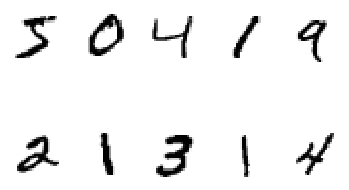

In [23]:
for i in range(10):
    plt.subplot(2,5,1+i)
    plt.axis('off')
    plt.imshow( xtr[i], cmap='gray_r')
plt.show()

In [24]:
#Defining the discriminator
def discriminator():
    model= Sequential()
    model.add(Dense(units=1024, input_dim=784))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(rate=0.3))
    model.add(Dense(units=512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(rate=0.3))
    model.add(Dense(units=256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    adam_optimizer= Adam(lr=0.002, beta_1=0.5)
    #compiling the model
    model.compile(loss= 'binary_crossentropy', optimizer= adam_optimizer, metrics=['accuracy'])
    return model

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)              

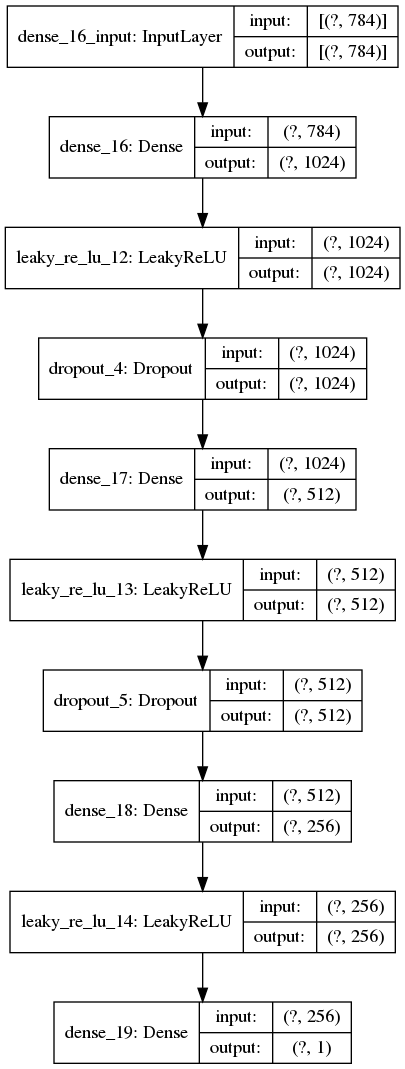

In [25]:
disc= discriminator()
disc.summary()
plot_model(disc, to_file='discriminator_plot.png', show_shapes=True)

In [26]:
def generator():
    model= Sequential()
    model.add(Dense(units=256, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(units=512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(units=1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(units=784, activation='tanh'))
    adam_optimizer= Adam(lr=0.002, beta_1=0.5)
    model.compile(loss= 'binary_crossentropy', optimizer= adam_optimizer)
    return model

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 784)              

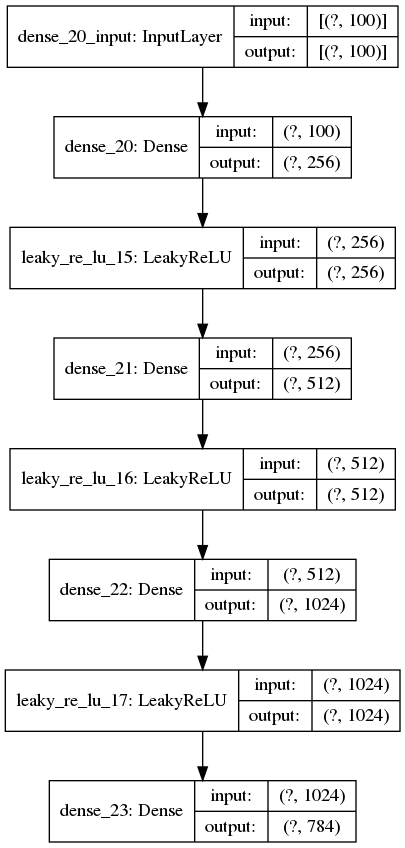

In [27]:
gen= generator()
gen.summary()
plot_model(gen, to_file='generator_plot.png', show_shapes=True)

In [28]:
def create_gan(disc, gen):
    disc.trainable=False
    gan_input= Input(shape=(100,))
    x= gen(gan_input)
    gan_output=disc(x)
    gan= Model(inputs= gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer= 'adam')
    return gan


In [29]:
gan= create_gan(disc, gen)
gan.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_5 (Sequential)    (None, 784)               1486352   
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


In [30]:
#function to plot generated images
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image %d.png' %epoch)

In [31]:
def train(epo=1, batchsize=128):
    #Step 1: loading the data
    (xtr,ytr),(xte,yte)= load_data()
    xtr= xtr.astype(np.float32)
    xtr= xtr/255
    xtr = xtr.reshape(60000, 784)
    batch_count= xtr.shape[0]/batchsize
    
    for i in range(1,epo+1):
        print('Epoch %d' %i)
        for _ in range(batchsize):
            #Generation of random noise
            noise= np.random.normal(0,1,size=[batchsize,100])
            generated_images = gen.predict(noise)
            # creating a batch of real images
            realbatch= xtr[np.random.randint(0,xtr.shape[0],size=batchsize)]
            #combining real and fake data
            x= np.concatenate([realbatch,generated_images])
            #labels for real and fake data for discriminator
            ydis=np.zeros(2*batchsize)
            ydis[:batchsize]=0.9
            #training the discriminator at first
            disc.trainable=True
            disc.train_on_batch(x,ydis)
            #fooling the generator by giving noised input as real data
            ygen= np.ones(batchsize)
            #Now freezing the discriminator weights
            disc.trainable=False
            #now we train the gan model
            gan.train_on_batch(noise, ygen)
        if i==1 or i%20==0:
            plot_generated_images(i,gen)
        

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
Epoch 100
Epoch 101
Epoch 102
Epoch 103
Epoch 104
Epoch 105
Epoch 106
Epoch 107
Epoch 108
Epoch 109
Epoch 110
Epoch 11

/home/rathore-adityasingh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 401
Epoch 402
Epoch 403
Epoch 404
Epoch 405
Epoch 406
Epoch 407
Epoch 408
Epoch 409
Epoch 410
Epoch 411
Epoch 412
Epoch 413
Epoch 414
Epoch 415
Epoch 416
Epoch 417
Epoch 418
Epoch 419
Epoch 420
Epoch 421
Epoch 422
Epoch 423
Epoch 424
Epoch 425
Epoch 426
Epoch 427
Epoch 428
Epoch 429
Epoch 430
Epoch 431
Epoch 432
Epoch 433
Epoch 434
Epoch 435
Epoch 436
Epoch 437
Epoch 438
Epoch 439
Epoch 440
Epoch 441
Epoch 442
Epoch 443
Epoch 444
Epoch 445
Epoch 446
Epoch 447
Epoch 448
Epoch 449
Epoch 450
Epoch 451
Epoch 452
Epoch 453
Epoch 454
Epoch 455
Epoch 456
Epoch 457
Epoch 458
Epoch 459
Epoch 460
Epoch 461
Epoch 462
Epoch 463
Epoch 464
Epoch 465
Epoch 466
Epoch 467
Epoch 468
Epoch 469
Epoch 470
Epoch 471
Epoch 472
Epoch 473
Epoch 474
Epoch 475
Epoch 476
Epoch 477
Epoch 478
Epoch 479
Epoch 480
Epoch 481
Epoch 482
Epoch 483
Epoch 484
Epoch 485
Epoch 486
Epoch 487
Epoch 488
Epoch 489
Epoch 490
Epoch 491
Epoch 492
Epoch 493
Epoch 494
Epoch 495
Epoch 496
Epoch 497
Epoch 498
Epoch 499
Epoch 500


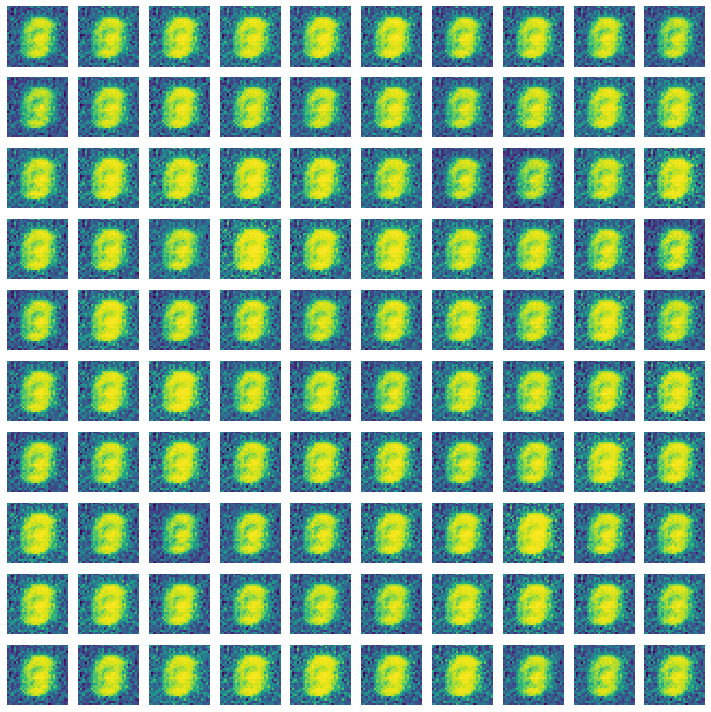

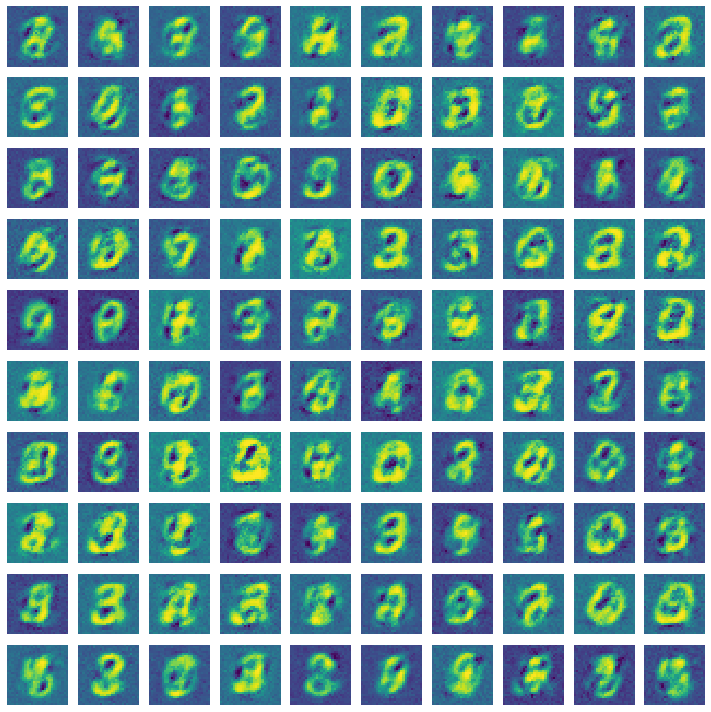

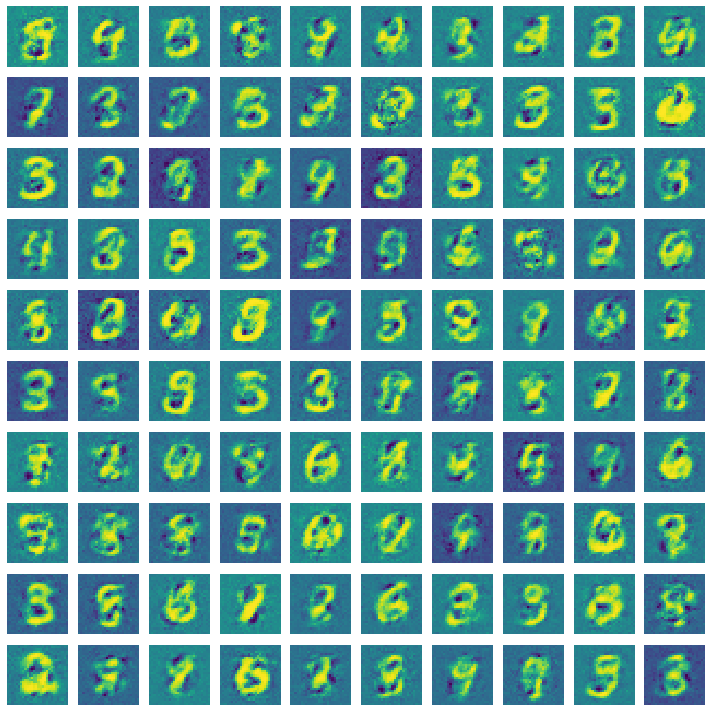

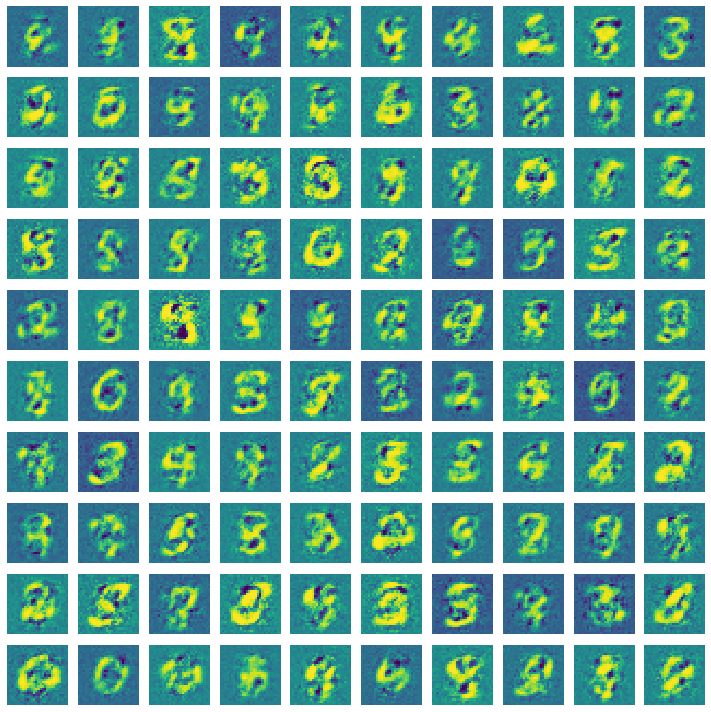

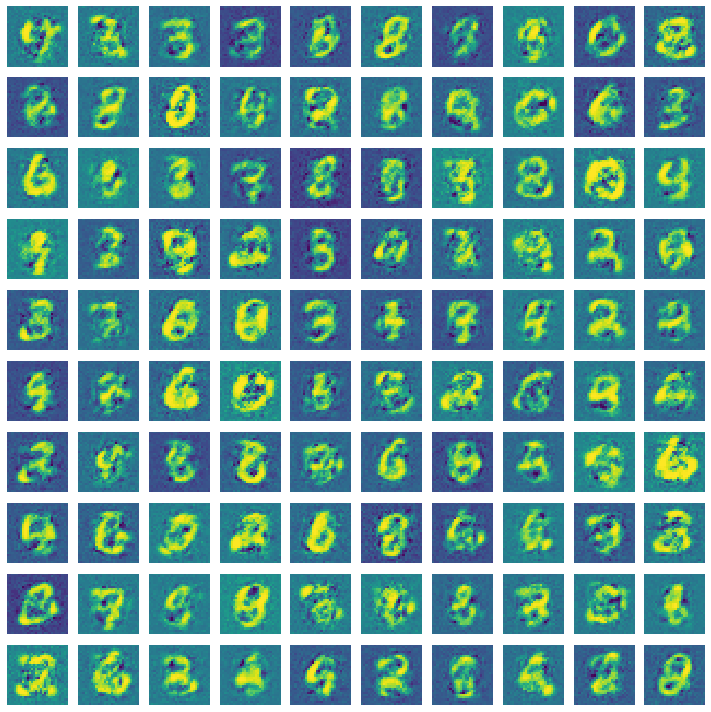

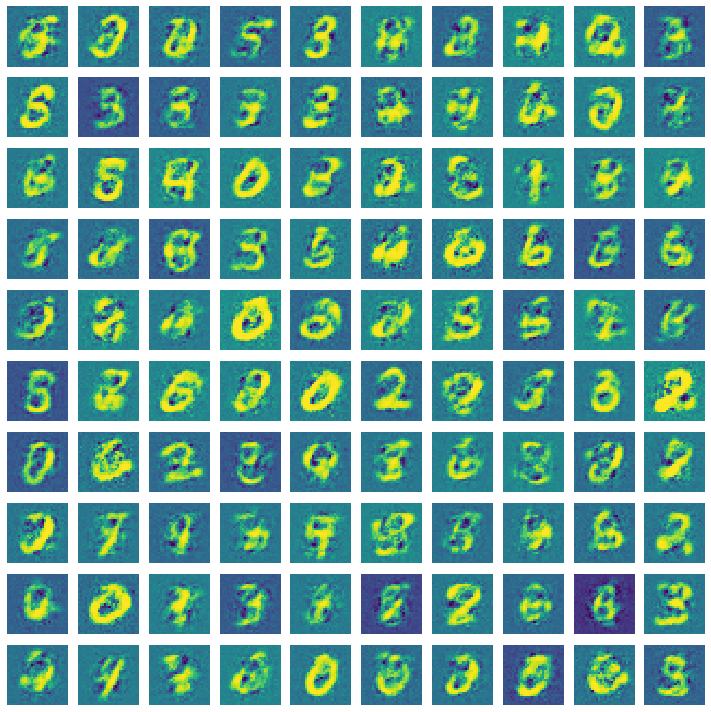

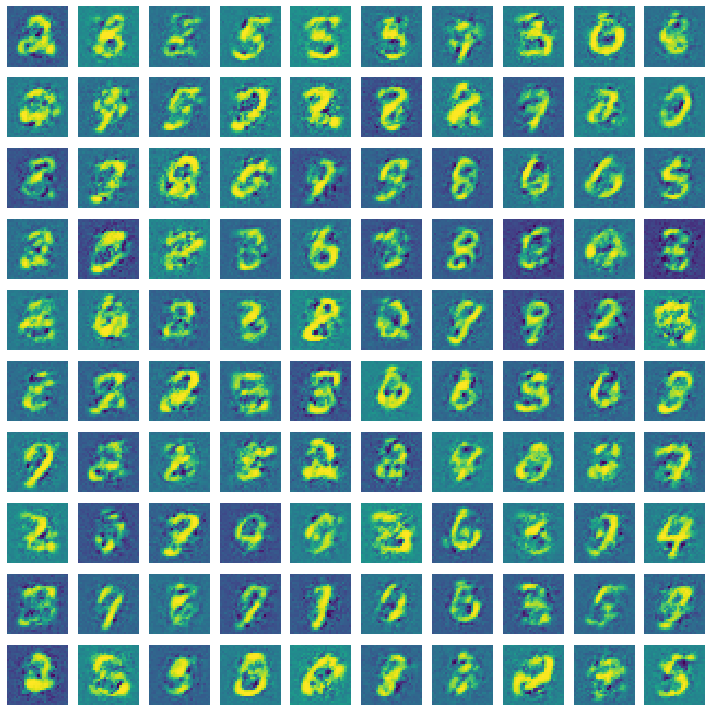

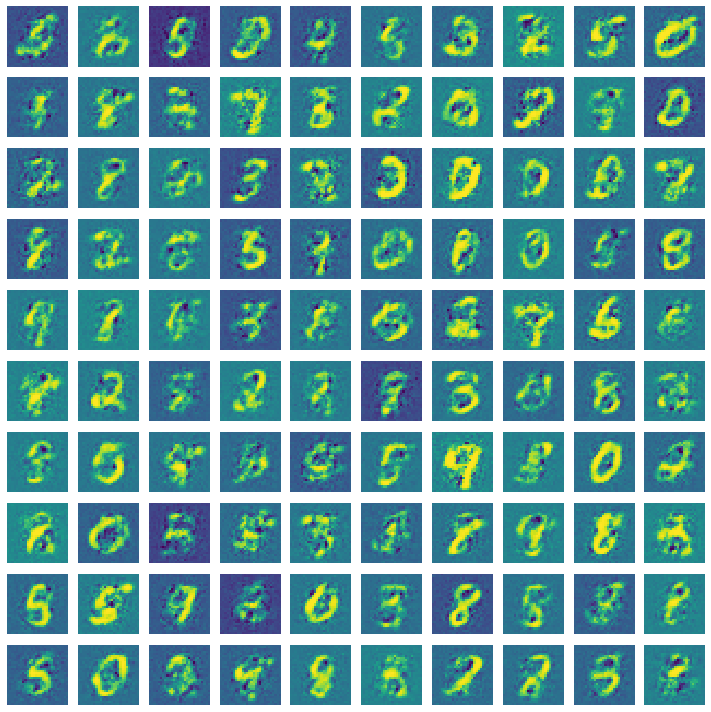

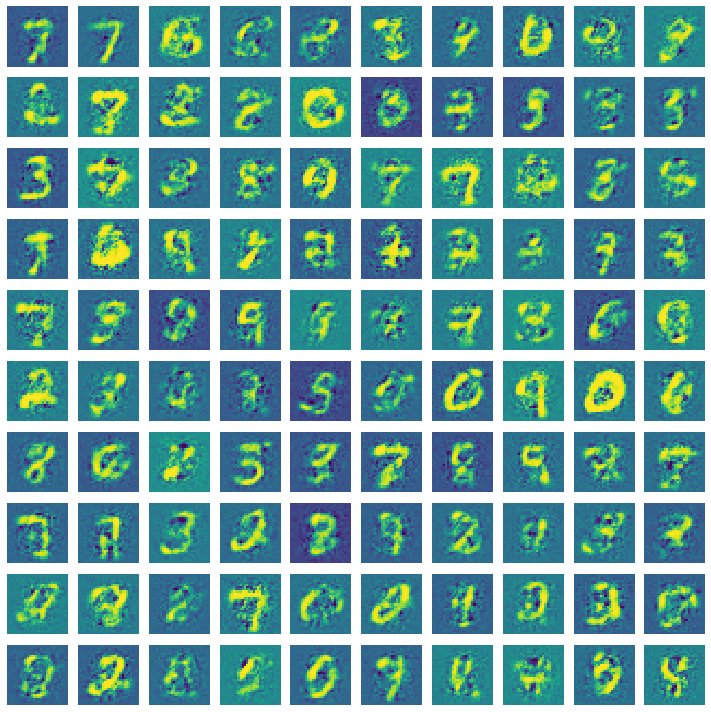

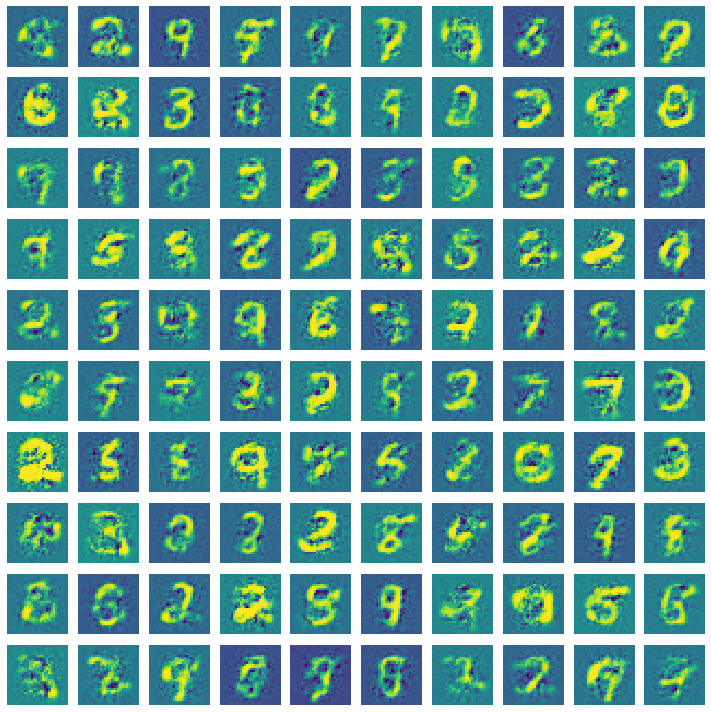

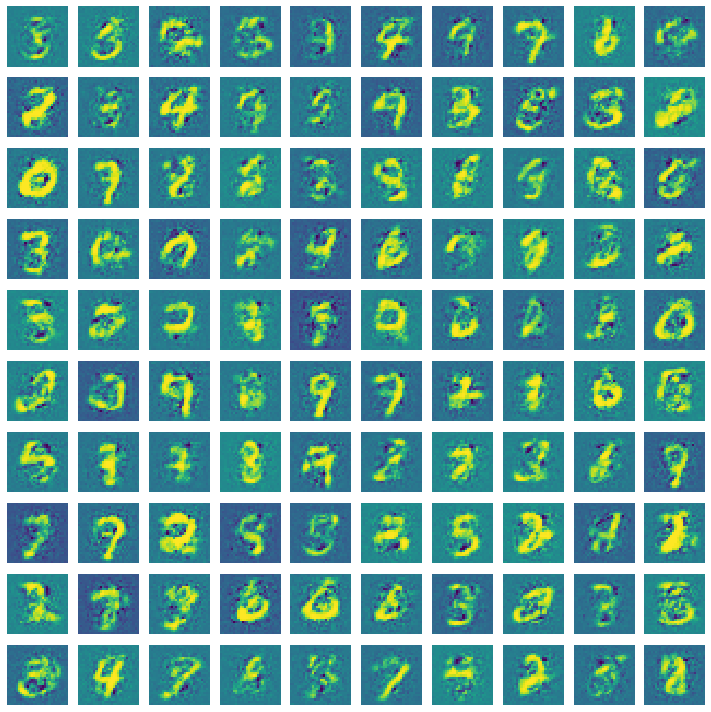

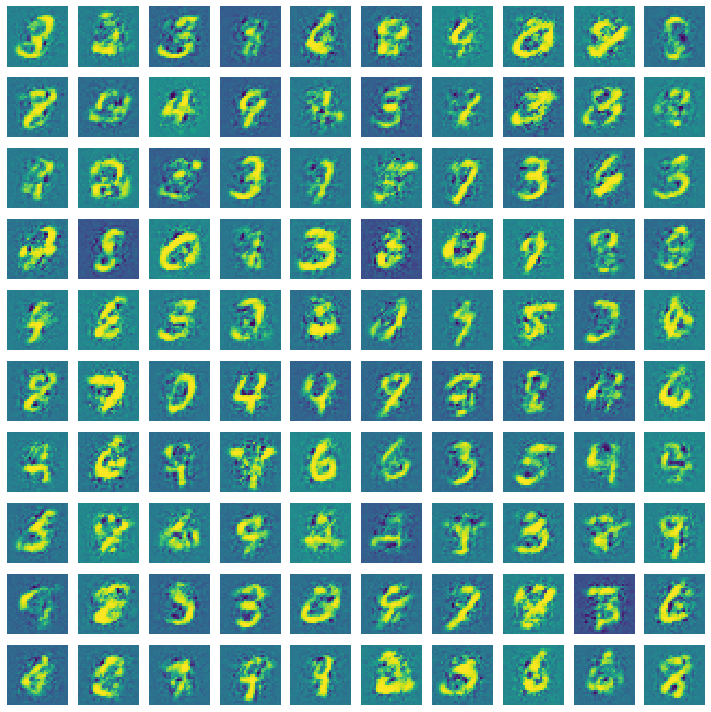

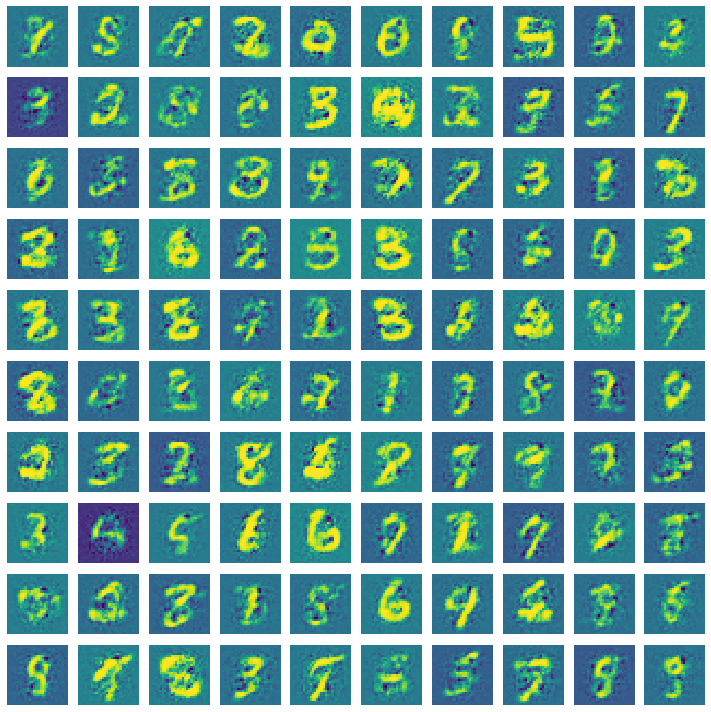

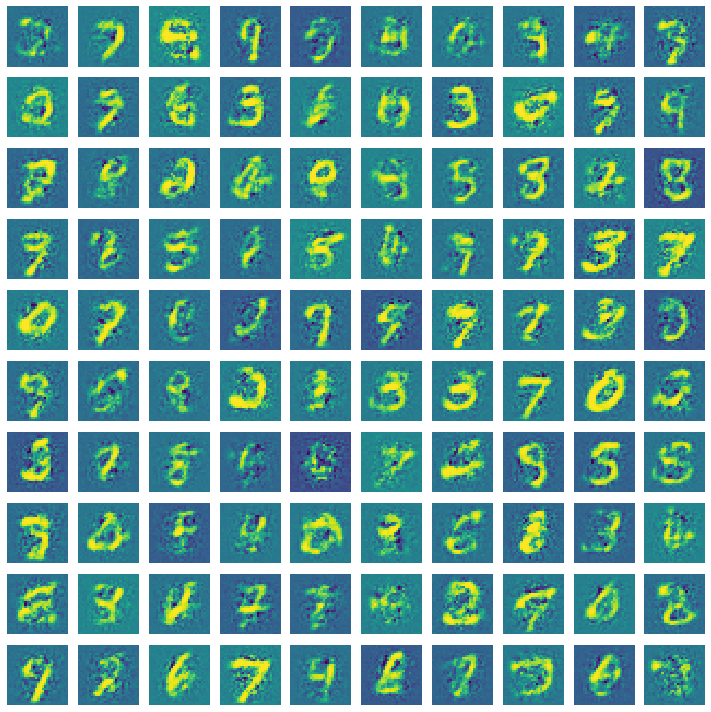

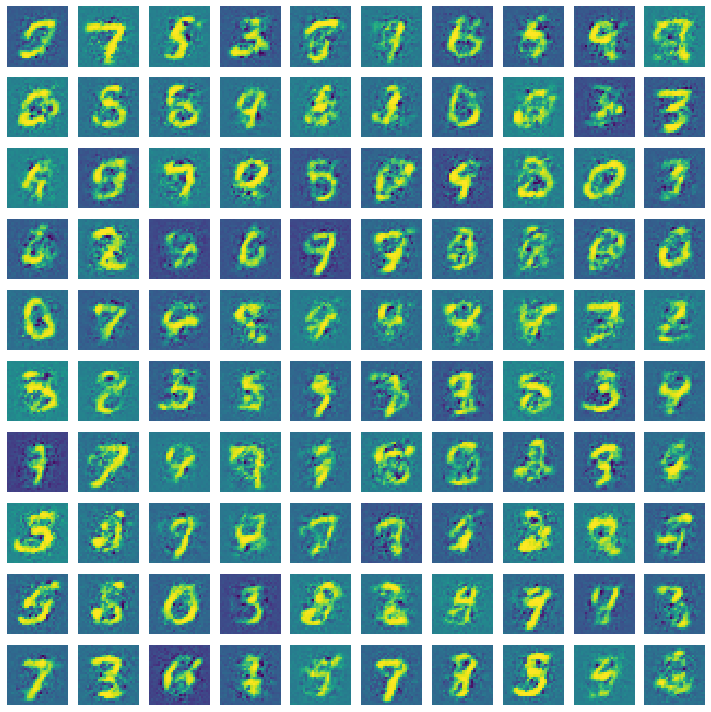

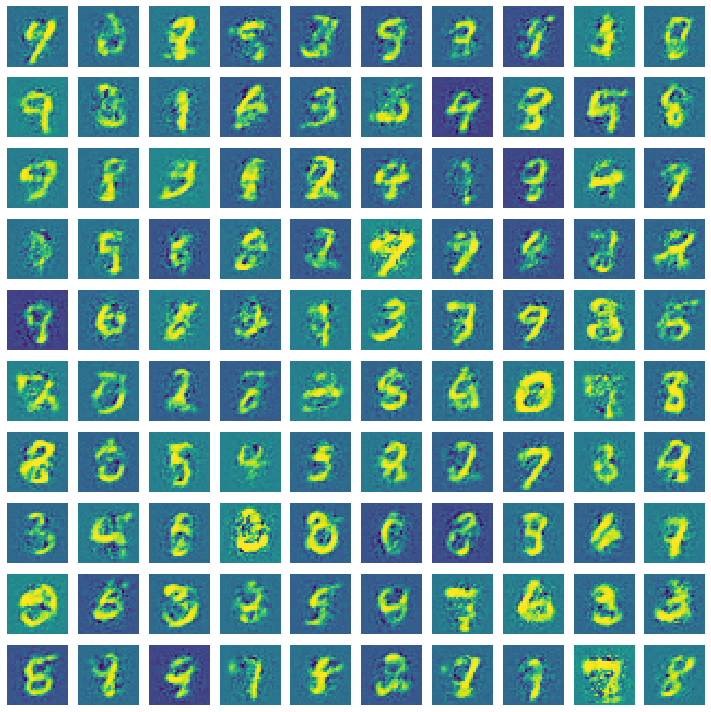

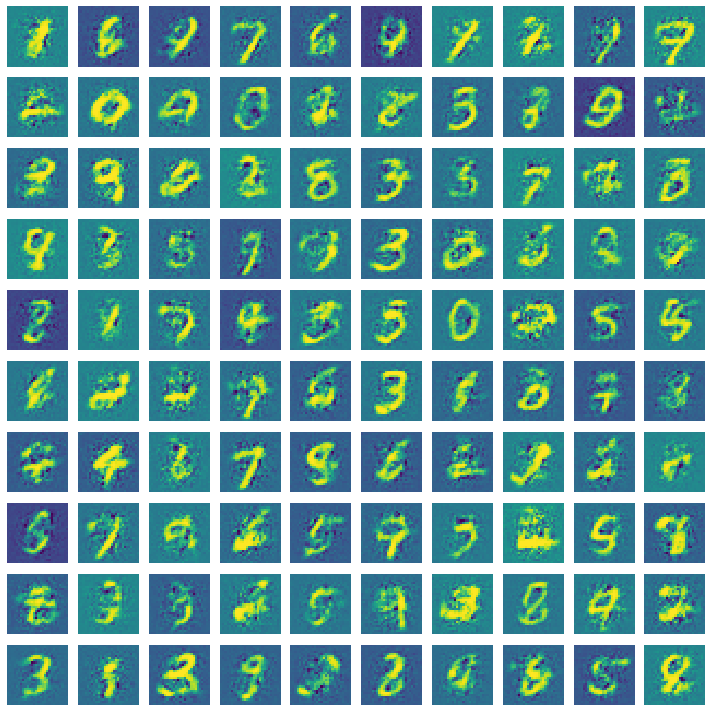

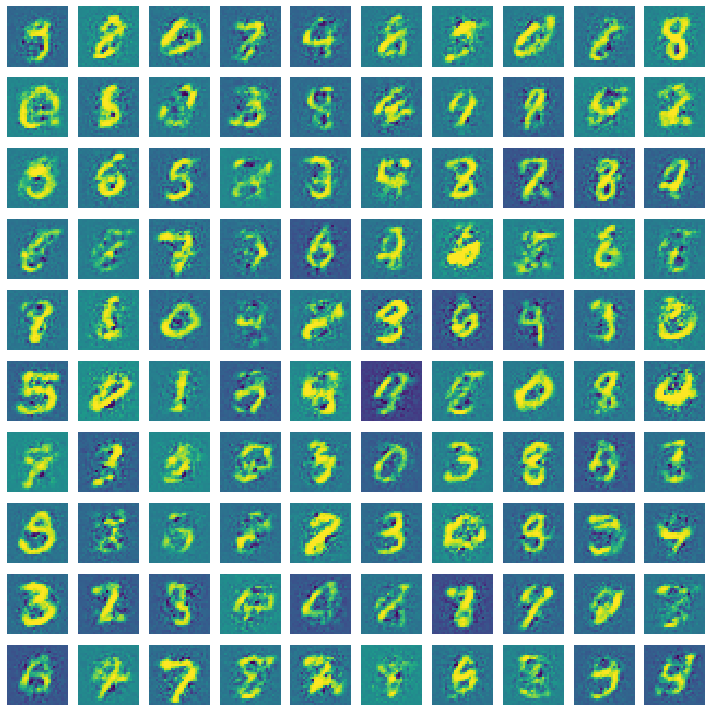

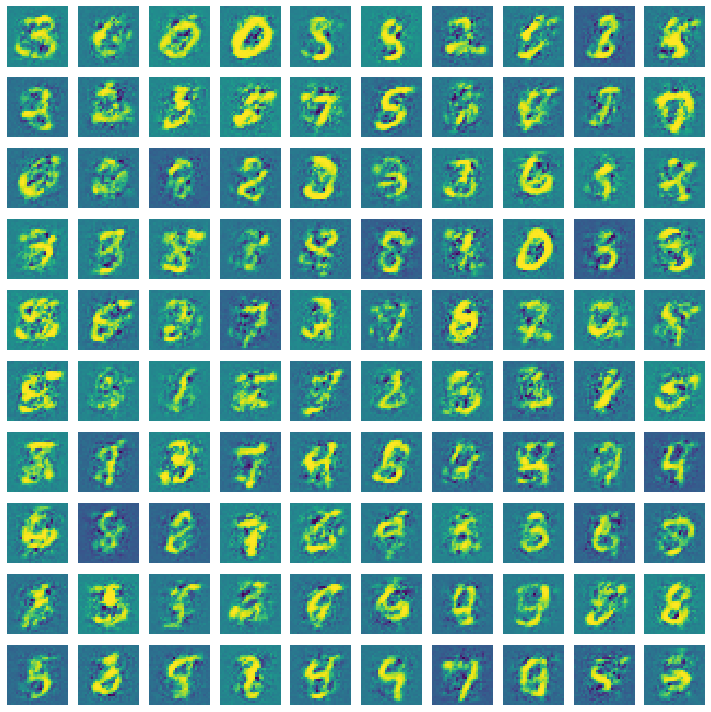

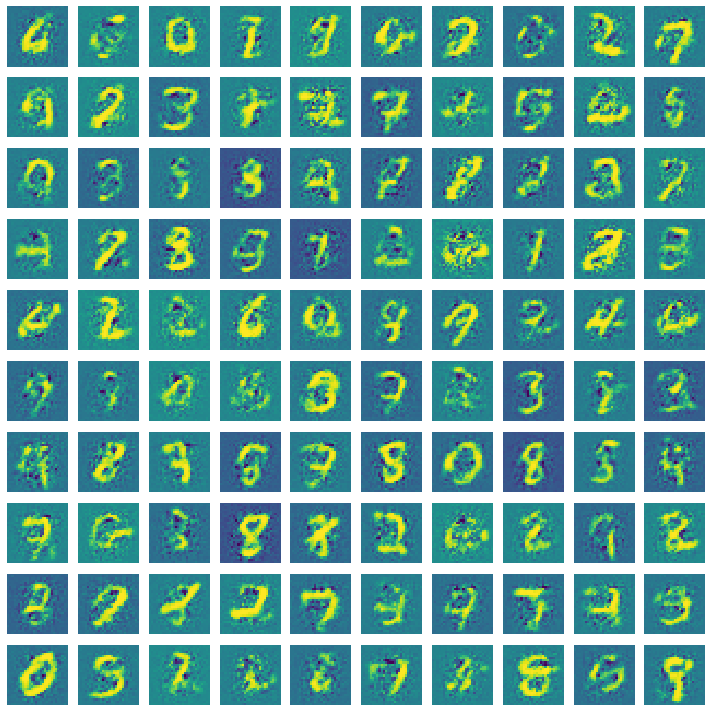

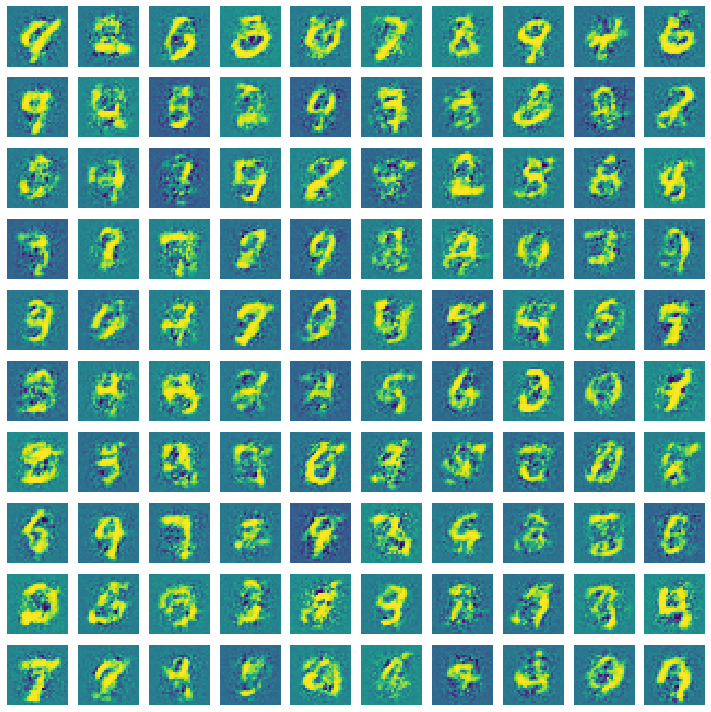

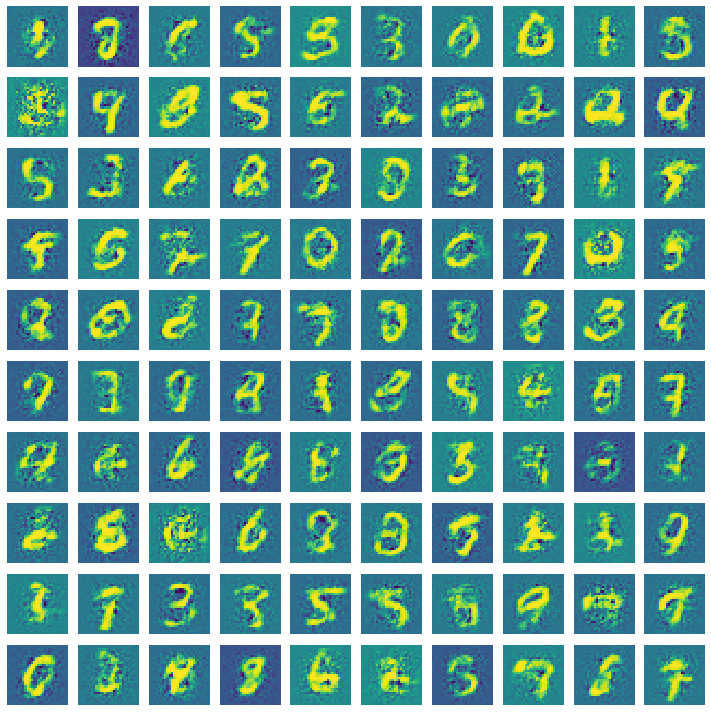

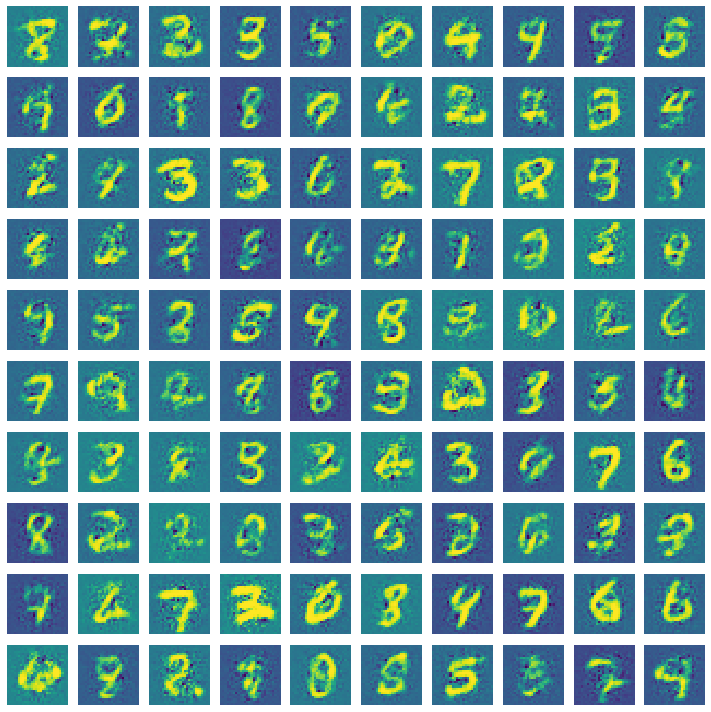

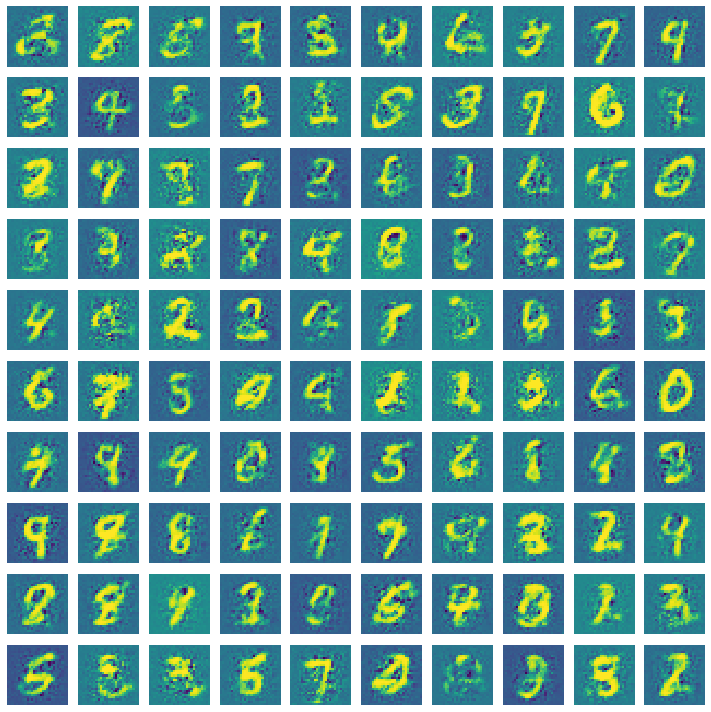

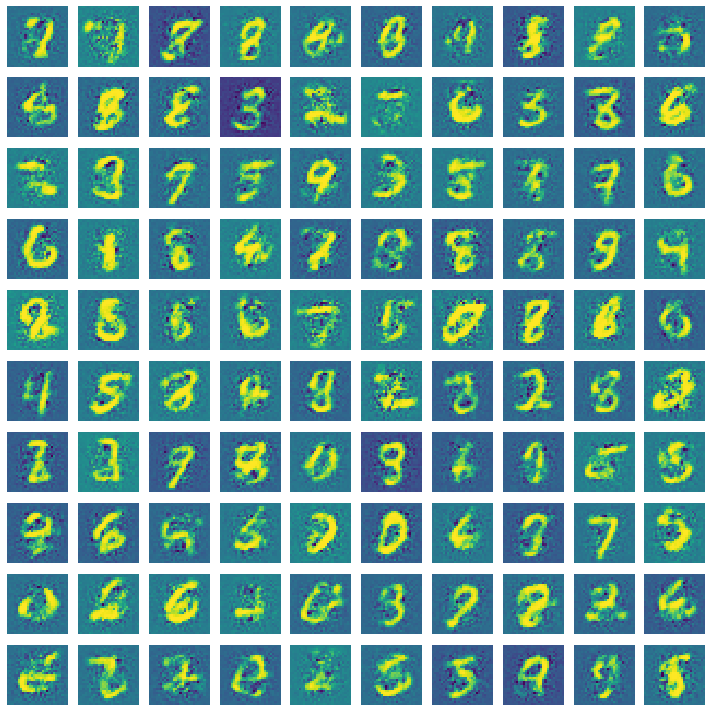

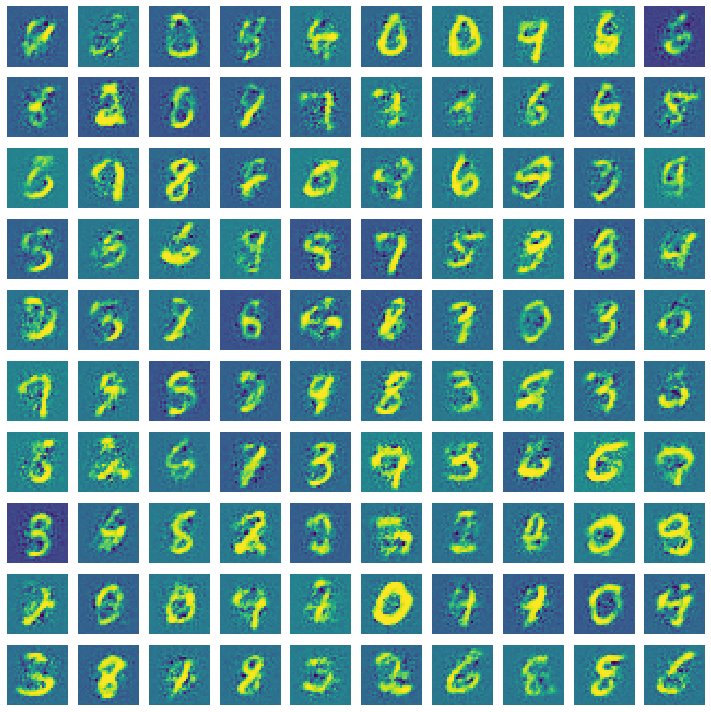

In [32]:
train(500)